In [5]:
from numpy import arange
from pandas import read_csv
import sklearn
from sklearn.model_selection import RepeatedKFold
from pandas import read_csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import random
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot

from joblib import Parallel, delayed
import joblib

In [6]:
######### 5 fold cross validation using COSMIC data; Fig 3B ###################

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# ---------------------------- MODEL WRAPPER ----------------------------
def get_model(name):
    if name == "SVM":
        return SVC(kernel='rbf', C=1, gamma=0.01, probability=True, random_state=42)
    elif name == "RandomForest":
        return RandomForestClassifier(n_estimators=1000, random_state=42)
    elif name == "AdaBoost":
        return AdaBoostClassifier(n_estimators=10, random_state=42)
    elif name == "GradientBoost":
        return GradientBoostingClassifier(n_estimators=50, learning_rate=0.4, max_depth=1, random_state=42)
    elif name == "LogisticRegression":
        return LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42)
    elif name == "ExtraTrees":
        return ExtraTreesClassifier(n_estimators=1000, random_state=42)

# ---------------------------- GET MODEL PARAMETERS STRING ----------------------------
def get_model_params_str(name, model):
    if name == "SVM":
        return f"kernel={model.kernel}, C={model.C}, gamma={model.gamma}"
    elif name == "RandomForest":
        return f"n_estimators={model.n_estimators}"
    elif name == "AdaBoost":
        return f"n_estimators={model.n_estimators}"
    elif name == "GradientBoost":
        return f"n_estimators={model.n_estimators}, lr={model.learning_rate}, max_depth={model.max_depth}"
    elif name == "LogisticRegression":
        return f"penalty={model.penalty}, C={model.C}"
    elif name == "ExtraTrees":
        return f"n_estimators={model.n_estimators}"

# ---------------------------- EVALUATE CV ----------------------------
def evaluate_and_plot_cv(model_name, X, y, save_path):
    model = get_model(model_name)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    tprs, aucs, mean_fpr = [], [], np.linspace(0, 1, 100)
    precisions, aps, mean_recall = [], [], np.linspace(0, 1, 100)

    for train_idx, test_idx in cv.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        y_score = model.predict_proba(X[test_idx])[:, 1]

        # ROC
        fpr, tpr, _ = roc_curve(y[test_idx], y_score)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

        # PR
        precision, recall, _ = precision_recall_curve(y[test_idx], y_score)
        interp_prec = np.interp(mean_recall, recall[::-1], precision[::-1])
        precisions.append(interp_prec)
        aps.append(average_precision_score(y[test_idx], y_score))

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    mean_prec = np.mean(precisions, axis=0)
    mean_ap = np.mean(aps)
    std_ap = np.std(aps)

    # Plot ROC Curve
    plt.figure(figsize=(7, 6))
    plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=3,
             label=f'Mean AUROC = {mean_auc:.3f} ± {std_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title(f'ROC Curve: {model_name}', fontsize=16, fontweight='bold')
    #plt.suptitle(f"Parameters: {get_model_params_str(model_name, model)}", fontsize=12, y=0.94, style='italic')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower right', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(f"{save_path}/{model_name}_ROC.pdf", format="pdf", bbox_inches='tight')
    plt.close()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(7, 6))
    plt.plot(mean_recall, mean_prec, color='darkgreen', lw=3,
             label=f'Mean AUPRC = {mean_ap:.3f} ± {std_ap:.3f}')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall', fontsize=14, fontweight='bold')
    plt.ylabel('Precision', fontsize=14, fontweight='bold')
    plt.title(f'Precision-Recall Curve: {model_name}', fontsize=16, fontweight='bold')
    #plt.suptitle(f"Parameters: {get_model_params_str(model_name, model)}", fontsize=12, y=0.94, style='italic')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower left', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(f"{save_path}/{model_name}_PR.pdf", format="pdf", bbox_inches='tight')
    plt.close()


# ---------------------------- MAIN ----------------------------
if __name__ == "__main__":
    train_url = "/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/Train/train_file_new"
    save_path = "/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset"

    df_train = read_csv(train_url, header=0)
    data = df_train.values
    X, y = data[:, :-1].astype(float), data[:, -1].astype(int)

    for model_name in ["SVM", "RandomForest", "AdaBoost", "GradientBoost", "LogisticRegression", "ExtraTrees"]:
        print(f"\n##### 5-Fold CV: {model_name} #####")
        evaluate_and_plot_cv(model_name, X, y, save_path)



##### 5-Fold CV: SVM #####

##### 5-Fold CV: RandomForest #####

##### 5-Fold CV: AdaBoost #####

##### 5-Fold CV: GradientBoost #####

##### 5-Fold CV: LogisticRegression #####

##### 5-Fold CV: ExtraTrees #####


In [9]:
def svc_model(X_train, y_train, X_test, y_test):
    clf = SVC(kernel='rbf', C=1, gamma=0.01, probability=True)
    clf.fit(X_train, y_train)
    np.random.seed(786)

    # make a prediction
    y_pred = clf.predict(X_test)
    y_pred1 = clf.predict_proba(X_test)
    # summarize prediction

    average_precision = precision_score(y_test, y_pred)
    print('Average precision score: {0:0.2f}'.format(average_precision))

    average_recall = recall_score(y_test, y_pred)
    print('Average recall score: {0:0.2f}'.format(average_recall))

    score_res = f1_score(y_test,y_pred)
    print("f1 on test data : %f" % score_res)

    score_res = accuracy_score(y_test,y_pred)
    print("Accuray on test data : %f" % score_res)

    score_res = roc_auc_score(y_test,y_pred1[:,1])
    print("roc_auc on test data : %f" % score_res)
    
    return(clf)

def random_forest_model(X_train, y_train, X_test, y_test):
    np.random.seed(786)

    clf = RandomForestClassifier(n_estimators=1000)
    clf.fit(X_train, y_train)

    # make a prediction
    y_pred = clf.predict(X_test)
    y_pred1 = clf.predict_proba(X_test)

    # summarize prediction

    average_precision = precision_score(y_test, y_pred)
    print('Average precision score: {0:0.2f}'.format(average_precision))

    average_recall = recall_score(y_test, y_pred)
    print('Average recall score: {0:0.2f}'.format(average_recall))

    score_res = f1_score(y_test,y_pred)
    print("f1 on test data : %f" % score_res)

    score_res = accuracy_score(y_test,y_pred)
    print("Accuray on test data : %f" % score_res)

    score_res = roc_auc_score(y_test,y_pred1[:,1])
    print("roc_auc on test data : %f" % score_res)
    
    return(clf)

def ada_boost_model(X_train, y_train, X_test, y_test):

    clf = AdaBoostClassifier(n_estimators=10)
    clf.fit(X_train, y_train)

    # make a prediction
    y_pred = clf.predict(X_test)
    y_pred1 = clf.predict_proba(X_test)

    # summarize prediction

    average_precision = precision_score(y_test, y_pred)
    print('Average precision score: {0:0.2f}'.format(average_precision))

    average_recall = recall_score(y_test, y_pred)
    print('Average recall score: {0:0.2f}'.format(average_recall))

    score_res = f1_score(y_test,y_pred)
    print("f1 on test data : %f" % score_res)

    score_res = accuracy_score(y_test,y_pred)
    print("Accuray on test data : %f" % score_res)

    score_res = roc_auc_score(y_test,y_pred1[:,1])
    print("roc_auc on test data : %f" % score_res)
    return(clf)

def gradient_boost_model(X_train, y_train, X_test, y_test):
    clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.4, max_depth=1, random_state=0)
    clf.fit(X_train, y_train)

    # make a prediction
    y_pred = clf.predict(X_test)
    y_pred1 = clf.predict_proba(X_test)

    # summarize prediction

    average_precision = precision_score(y_test, y_pred)
    print('Average precision score: {0:0.2f}'.format(average_precision))

    average_recall = recall_score(y_test, y_pred)
    print('Average recall score: {0:0.2f}'.format(average_recall))

    score_res = f1_score(y_test,y_pred)
    print("f1 on test data : %f" % score_res)

    score_res = accuracy_score(y_test,y_pred)
    print("Accuray on test data : %f" % score_res)

    score_res = roc_auc_score(y_test,y_pred1[:,1])
    print("roc_auc on test data : %f" % score_res)
    return(clf)
    
def logistic_regression_model(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear')
    clf.fit(X_train, y_train)

    # make a prediction
    y_pred = clf.predict(X_test)

    # summarize prediction

    average_precision = precision_score(y_test, y_pred)
    print('Average precision score: {0:0.2f}'.format(average_precision))

    average_recall = recall_score(y_test, y_pred)
    print('Average recall score: {0:0.2f}'.format(average_recall))

    score_res = f1_score(y_test,y_pred)
    print("f1 on test data : %f" % score_res)

    score_res = accuracy_score(y_test,y_pred)
    print("Accuray on test data : %f" % score_res)

    score_res = roc_auc_score(y_test,y_pred)
    print("roc_auc on test data : %f" % score_res)
    return(clf)

def extra_trees_model(X_train, y_train, X_test, y_test):
    clf = ExtraTreesClassifier(n_estimators=100, random_state=2)
    clf.fit(X_train, y_train)

    # make a prediction
    y_pred = clf.predict(X_test)

    # summarize prediction

    average_precision = precision_score(y_test, y_pred)
    print('Average precision score: {0:0.2f}'.format(average_precision))

    average_recall = recall_score(y_test, y_pred)
    print('Average recall score: {0:0.2f}'.format(average_recall))

    score_res = f1_score(y_test,y_pred)
    print("f1 on test data : %f" % score_res)

    score_res = accuracy_score(y_test,y_pred)
    print("Accuray on test data : %f" % score_res)

    score_res = roc_auc_score(y_test,y_pred)
    print("roc_auc on test data : %f" % score_res)
    return(clf)

In [ ]:
#### This is Piyush version of the above code with updated scikit and plot function ###

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from pandas import read_csv

# Create ROC plot axes for each model
fig_svm, ax_svm = plt.subplots()
fig_rf, ax_rf = plt.subplots()
fig_ada, ax_ada = plt.subplots()
fig_gb, ax_gb = plt.subplots()
fig_log, ax_log = plt.subplots()
fig_extra, ax_extra = plt.subplots()

# File paths
train_url = "/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/Train/train_file"
test_url = "/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/benchmark/test_file"
#train_url = "/Users/piyushagrawal/Downloads/Annan_Project/ppi_analysis/machine_learning/STRING_S_EXP_total_fraction_train.csv"
#test_url = "/Users/piyushagrawal/Downloads/Annan_Project/ppi_analysis/machine_learning/STRING_S_EXP_total_fraction_test.csv"

# Read full training data for feature count
dataframe_train_full = read_csv(train_url, header=0)

for feat in range(1, len(dataframe_train_full.columns)):
    print(f"\n======= Processing feature subset: {feat} =======")

    # Load training data
    dataframe_train = read_csv(train_url, header=0)
    data_train = dataframe_train.values
    X_train, y_train = data_train[:, :-feat], data_train[:, -1]

    # Load test data
    dataframe_test = read_csv(test_url, header=0)
    data_test = dataframe_test.values
    X_test, y_test = data_test[:, :-feat], data_test[:, -1]

    # Train models with logging
    print("####### Support Vector Classifier ####")
    svm_clf = svc_model(X_train, y_train, X_test, y_test)

    print("####### Random Forest Classifier ####")
    rf_clf = random_forest_model(X_train, y_train, X_test, y_test)

    print("####### AdaBoost Classifier ####")
    ada_boost_clf = ada_boost_model(X_train, y_train, X_test, y_test)

    print("####### Gradient Boost Classifier ####")
    gradient_boost_clf = gradient_boost_model(X_train, y_train, X_test, y_test)

    print("####### Logistic Regression Classifier ####")
    log_reg_clf = logistic_regression_model(X_train, y_train, X_test, y_test)

    print("####### Extra Trees Classifier ####")
    extra_trees_clf = extra_trees_model(X_train, y_train, X_test, y_test)

    curve_name = f"Features-{len(dataframe_train.columns) - feat}"

    # Plot ROC curves
    RocCurveDisplay.from_estimator(svm_clf, X_test, y_test, name=curve_name, ax=ax_svm)
    RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, name=curve_name, ax=ax_rf)
    RocCurveDisplay.from_estimator(ada_boost_clf, X_test, y_test, name=curve_name, ax=ax_ada)
    RocCurveDisplay.from_estimator(gradient_boost_clf, X_test, y_test, name=curve_name, ax=ax_gb)
    RocCurveDisplay.from_estimator(log_reg_clf, X_test, y_test, name=curve_name, ax=ax_log)
    RocCurveDisplay.from_estimator(extra_trees_clf, X_test, y_test, name=curve_name, ax=ax_extra)

# Add chance diagonal
for ax in [ax_svm, ax_rf, ax_ada, ax_gb, ax_log, ax_extra]:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")


# Set titles
ax_svm.set_title("SVM ROC Curves")
ax_rf.set_title("Random Forest ROC Curves")
ax_ada.set_title("AdaBoost ROC Curves")
ax_gb.set_title("Gradient Boost ROC Curves")
ax_log.set_title("Logistic Regression ROC Curves")
ax_extra.set_title("Extra Trees ROC Curves")

# Layout
fig_svm.tight_layout(); fig_rf.tight_layout(); fig_ada.tight_layout()
fig_gb.tight_layout(); fig_log.tight_layout(); fig_extra.tight_layout()

# Save as PDFs
fig_svm.savefig("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/SVM_ROC.pdf", format="pdf", bbox_inches='tight')
fig_rf.savefig("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/RandomForest_ROC.pdf", format="pdf", bbox_inches='tight')
fig_ada.savefig("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/AdaBoost_ROC.pdf", format="pdf", bbox_inches='tight')
fig_gb.savefig("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/GradientBoost_ROC.pdf", format="pdf", bbox_inches='tight')
fig_log.savefig("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/LogisticRegression_ROC.pdf", format="pdf", bbox_inches='tight')
fig_extra.savefig("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/ExtraTrees_ROC.pdf", format="pdf", bbox_inches='tight')

# Show plots
plt.show()

In [ ]:
######## Performance Metrix Saving ##########


======= Processing feature subset: 1 =======
####### Support Vector Classifier ####
Average precision score: 0.63
Average recall score: 0.72
f1 on test data : 0.669366
Accuray on test data : 0.612954
roc_auc on test data : 0.658964
####### Random Forest Classifier ####
Average precision score: 0.74
Average recall score: 0.73
f1 on test data : 0.739226
Accuray on test data : 0.718009
roc_auc on test data : 0.792033
####### AdaBoost Classifier ####
Average precision score: 0.65
Average recall score: 0.66
f1 on test data : 0.652768
Accuray on test data : 0.618483
roc_auc on test data : 0.670329
####### Gradient Boost Classifier ####
Average precision score: 0.68
Average recall score: 0.66
f1 on test data : 0.670606
Accuray on test data : 0.647709
roc_auc on test data : 0.708599
####### Logistic Regression Classifier ####
Average precision score: 0.64
Average recall score: 0.73
f1 on test data : 0.684783
Accuray on test data : 0.633491
roc_auc on test data : 0.623980
####### Extra Trees C

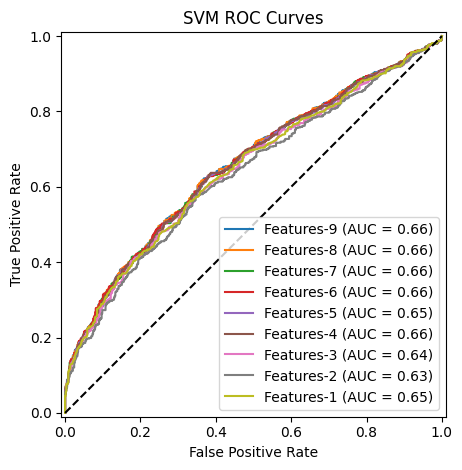

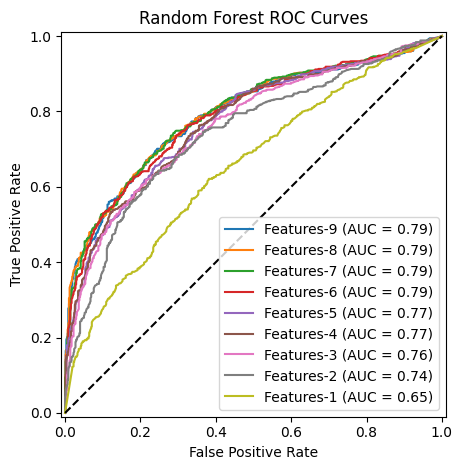

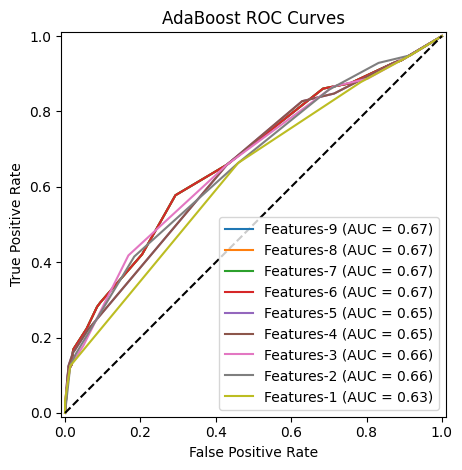

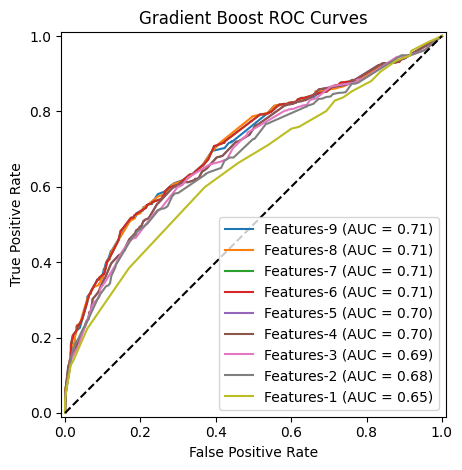

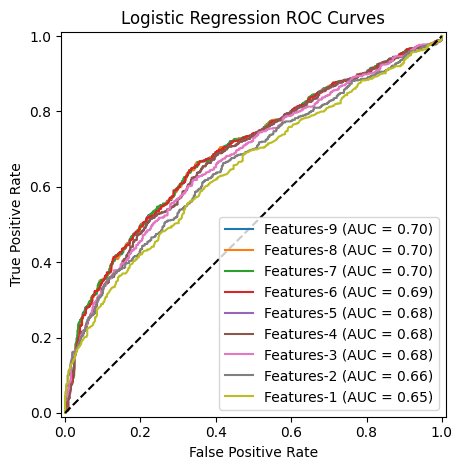

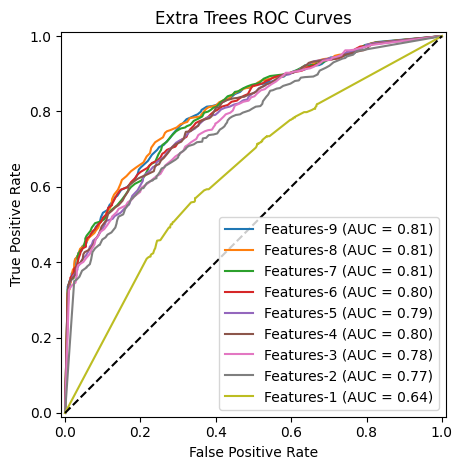

In [11]:
####### Code for saving the Perfromance Values into TSV file format ########

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, precision_score, recall_score, accuracy_score, roc_auc_score
from pandas import read_csv
import pandas as pd

# Create ROC plot axes for each model
fig_svm, ax_svm = plt.subplots()
fig_rf, ax_rf = plt.subplots()
fig_ada, ax_ada = plt.subplots()
fig_gb, ax_gb = plt.subplots()
fig_log, ax_log = plt.subplots()
fig_extra, ax_extra = plt.subplots()

# File paths
train_url = "/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/Train/train_file"
test_url = "/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/oncoGene/test_file"

# Read full training data for feature count
dataframe_train_full = read_csv(train_url, header=0)

# Prepare to store metrics
results = []

# Evaluation function
def evaluate_model(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else float('nan')
    }

for feat in range(1, len(dataframe_train_full.columns)):
    print(f"\n======= Processing feature subset: {feat} =======")

    # Load training data
    dataframe_train = read_csv(train_url, header=0)
    data_train = dataframe_train.values
    X_train, y_train = data_train[:, :-feat], data_train[:, -1]

    # Load test data
    dataframe_test = read_csv(test_url, header=0)
    data_test = dataframe_test.values
    X_test, y_test = data_test[:, :-feat], data_test[:, -1]

    # Train models
    print("####### Support Vector Classifier ####")
    svm_clf = svc_model(X_train, y_train, X_test, y_test)

    print("####### Random Forest Classifier ####")
    rf_clf = random_forest_model(X_train, y_train, X_test, y_test)

    print("####### AdaBoost Classifier ####")
    ada_boost_clf = ada_boost_model(X_train, y_train, X_test, y_test)

    print("####### Gradient Boost Classifier ####")
    gradient_boost_clf = gradient_boost_model(X_train, y_train, X_test, y_test)

    print("####### Logistic Regression Classifier ####")
    log_reg_clf = logistic_regression_model(X_train, y_train, X_test, y_test)

    print("####### Extra Trees Classifier ####")
    extra_trees_clf = extra_trees_model(X_train, y_train, X_test, y_test)

    curve_name = f"Features-{len(dataframe_train.columns) - feat}"

    # Plot ROC curves
    RocCurveDisplay.from_estimator(svm_clf, X_test, y_test, name=curve_name, ax=ax_svm)
    RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, name=curve_name, ax=ax_rf)
    RocCurveDisplay.from_estimator(ada_boost_clf, X_test, y_test, name=curve_name, ax=ax_ada)
    RocCurveDisplay.from_estimator(gradient_boost_clf, X_test, y_test, name=curve_name, ax=ax_gb)
    RocCurveDisplay.from_estimator(log_reg_clf, X_test, y_test, name=curve_name, ax=ax_log)
    RocCurveDisplay.from_estimator(extra_trees_clf, X_test, y_test, name=curve_name, ax=ax_extra)

    # Evaluate and collect results
    for model_name, clf in [
        ("SVM", svm_clf),
        ("RandomForest", rf_clf),
        ("AdaBoost", ada_boost_clf),
        ("GradientBoost", gradient_boost_clf),
        ("LogisticRegression", log_reg_clf),
        ("ExtraTrees", extra_trees_clf)
    ]:
        metrics = evaluate_model(clf, X_test, y_test)
        results.append({
            "Feature_Set": len(dataframe_train.columns) - feat,
            "Model": model_name,
            **metrics
        })

# Add chance diagonal
for ax in [ax_svm, ax_rf, ax_ada, ax_gb, ax_log, ax_extra]:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

# Set titles
ax_svm.set_title("SVM ROC Curves")
ax_rf.set_title("Random Forest ROC Curves")
ax_ada.set_title("AdaBoost ROC Curves")
ax_gb.set_title("Gradient Boost ROC Curves")
ax_log.set_title("Logistic Regression ROC Curves")
ax_extra.set_title("Extra Trees ROC Curves")

# Layout
fig_svm.tight_layout(); fig_rf.tight_layout(); fig_ada.tight_layout()
fig_gb.tight_layout(); fig_log.tight_layout(); fig_extra.tight_layout()

# Save evaluation metrics to TSV
results_df = pd.DataFrame(results)
results_df.to_csv("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/Bal_model_metrics.tsv", sep='\t', index=False)

# Show plots
#plt.show()

In [ ]:
########## Model Saving ############

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import joblib

# Load CSV with header
df = pd.read_csv("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/Train/train_file")  # header is read by default

# Split into features and label
X = df.drop(columns=["Label"])
y = df["Label"]

# Optional: split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = ExtraTreesClassifier(n_estimators=100, random_state=2)
clf.fit(X_train, y_train)

# Save model
joblib.dump(clf, "/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/Train/UNITe_trained_model.pkl")

# Optional: save column order for later prediction
X.columns.to_series().to_csv("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/Train/model_features.txt", index=False, header=False)


In [ ]:
######## Predicting genome wide #######

In [6]:
# Load model
model = joblib.load("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/genome_wide/UNITe_trained_model.pkl")

# Load genome-wide data with header
genome_df = pd.read_csv("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/genome_wide/genomewide_file.csv")  # Assume same feature structure without 'Label'

# Ensure same feature order
with open("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/genome_wide/model_features.txt") as f:
    feature_order = f.read().splitlines()

X_genome = genome_df[feature_order]  # Reorder columns as in training

# Predict probabilities
probs = model.predict_proba(X_genome)

# Save predictions
results = pd.DataFrame({
    "GeneID": genome_df.index,  # Change if you have a GeneID column
    "Probability_Class_0": probs[:, 0],
    "Probability_Class_1": probs[:, 1]
})

results.to_csv("/Users/piyushagrawal/Downloads/Annan_Project/Briefings_paper/STRING_work/ml/based_on_piyush_train_dataset/genome_wide/genome_predictions.csv", index=False)
